# Propagation d'incertitudes

## Question de cours: intervalles de tolérance avec  95% de confiance
Soit $X$ une variable aléatoire gaussienne centrée réduite $X\sim \mathcal{G}(0,1)$

- Calculer l'intervalle de tolérance à $92\%$ de cette variable aléatoire
- Choisir un nombre de tirage $N$ et vérifier expérimentalement que plus de $92\%$ des estimations des intervalles calculés avec les **quantiles de Wilks** englobent bien l'intervalle analytique 95% du temps (ne cherchez pas, les quantiles de Wilks ne sont codés dans aucun package... Il faut le faire à la main). 

D'une certaine manière, vous avez vérifié l'implémentation de votre estimateur du quantile de Wilks

### 1. Calcul de l'intervalle analytique

On définit: 

- **Proportion $\gamma$** :  
  La proportion de la population à inclure dans l'intervalle ($92\%$).

- **Quantiles** :  
  - Le quantile inférieur ($4\%$) est calculé comme :  
    $
    \frac{1 - \gamma}{2}
    $
  - Le quantile supérieur ($96\%$) est calculé comme :  
    $
    1 - \frac{1 - \gamma}{2}
    $

- **Intervalle** :  
  On utilise la fonction `norm.ppf` de `scipy.stats` pour trouver les quantiles de la distribution normale centrée réduite.  
  Cela donne les bornes inférieure et supérieure de l'intervalle.



In [1]:
from scipy.stats import norm
gamma = 0.92
lower_quantile = (1 - gamma) / 2  # 4%
upper_quantile = 1 - lower_quantile  # 96%
lower_bound = norm.ppf(lower_quantile)  # Quantile inf
upper_bound = norm.ppf(upper_quantile)  # Quantile sup
print(f"Intervalle de tolérance à {gamma * 100}% : [{lower_bound:.4f}, {upper_bound:.4f}]")


Intervalle de tolérance à 92.0% : [-1.7507, 1.7507]


### 2. Vérification expérimentale avec les quantiles de Wilks

#### a. Principe des quantiles de Wilks

Les *quantiles de Wilks* permettent de déterminer un intervalle de tolérance basé sur un échantillon de taille $ N $, garantissant avec une certaine confiance $ \beta $ que l'intervalle contient au moins une proportion $ \gamma $ de la population.

La *formule* pour le degré de confiance $ \beta $ est :
$
\beta = 1 - 2 \sum_{i=0}^{k-1} \binom{N}{i} \gamma^{N-i} (1 - \gamma)^i
$
Où :
- $ N $ est la taille de l'échantillon.
- $ \gamma $ est la proportion de la population couverte par l'intervalle (ici $ \gamma = 0.92 $).
- $ k $ est le nombre de valeurs extrêmes à exclure de chaque côté de l'échantillon pour obtenir l'intervalle.

Cette formule est équivalente à la formule du cours:
$
1 - \sum_{i=N-r+1}^{N} \binom{N}{i} \gamma^i (1-\gamma)^{N-i} \geq \beta
$

(J'ai essayé de coder la formule du cours, mais je n'arrive pas à avoir de le $\beta$ attendu).

Objectif :* Trouver le plus petit $ k $ tel que $ \beta \geq 0.95 $ (95% de confiance).

#### b. Calcul de  k 

Pour déterminer $ k $, nous devons résoudre l'équation :
$
\beta = 1 - 2 \sum_{i=0}^{k-1} \binom{N}{i} \gamma^{N-i} (1 - \gamma)^i \geq 0.95
$
Ce qui revient à :
$
\sum_{i=0}^{k-1} \binom{N}{i} \gamma^{N-i} (1 - \gamma)^i \leq \frac{1 - \beta}{2} = 0.025
$

Pour simplifier le calcul, nous pouvons modéliser le nombre de "succès" \( X \) (valeurs extrêmes) comme une variable aléatoire suivant une distribution binomiale :
$
X \sim \text{Binom}(N, p)
$
Où :
$
p = \frac{1 - \gamma}{2} = 0.04
$

Nous cherchons alors le plus petit $ k $ tel que :
$
P(X \leq k - 1) \leq 0.025
$

Cela peut être trouvé en utilisant la fonction de répartition inverse de la distribution binomiale (binom.ppf) de la bibliothèque scipy.stats.

In [2]:
import numpy as np
from scipy.stats import norm, binom
import matplotlib.pyplot as plt

def determine_k(N, gamma, beta):
    """
    Détermine le nombre de valeurs extrêmes à exclure de chaque côté (k)
    pour un intervalle de tolérance basé sur les quantiles de Wilks.
    
    Arguments :
    - N : int, taille de l'échantillon
    - gamma : float, proportion de la population couverte (ex. 0.92)
    - beta : float, niveau de confiance souhaité (ex. 0.95)
    
    Retourne :
    - k : int, nombre de valeurs extrêmes à exclure de chaque côté
    """
    # Calcul de p pour la distribution binomiale
    p = (1 - gamma) / 2  # p = 0.04 pour gamma=0.92
    
    # Trouver k tel que P(X <= k-1) <= (1 - beta)/2 = 0.025
    q = (1 - beta) / 2  # 0.025
        
    # k doit être un entier
    k = int(np.ceil(binom.ppf(q, N, p)))
    
    return k


In [6]:
def wilks_confidence_level(N, gamma, k):
    """
    Calcule le degré de confiance beta pour les quantiles de Wilks.
    
    Arguments :
    - N : int, taille de l'échantillon
    - gamma : float, proportion de la population couverte
    - k : int, nombre de valeurs extrêmes exclues de chaque côté
    
    Retourne :
    - beta : float, degré de confiance associé
    """
    p = (1 - gamma) / 2  # 0.04
    # Calcul de la probabilité cumulée jusqu'à k-1
    cumulative = binom.cdf(k - 1, N, p)
    # Degré de confiance
    beta_calculé = 1 - 2 * cumulative
    return beta_calculé

# Paramètres
gamma = 0.92  # Proportion de la population couverte
beta_target = 0.95  # Niveau de confiance souhaité
N = 10000  # Taille de l'échantillon
M = 5000  # Nombre de simulations Monte Carlo

# 1. Déterminer k
k = determine_k(N, gamma, beta_target)
print(f"Nombre de valeurs extrêmes à exclure de chaque côté : k = {k}")

# 2. Calculer le degré de confiance associé
beta_calculé = wilks_confidence_level(N, gamma, k)
print(f"Degré de confiance calculé avec k={k} : {beta_calculé*100:.2f}%")

# 3. Définir l'intervalle analytique à vérifier
z_analytic = norm.ppf(0.96)  # Pour 92% de l'intervalle symétrique
interval_analytic = (-z_analytic, z_analytic)
print(f"Intervalle analytique à vérifier : {interval_analytic}")

# 4. Simulation Monte Carlo
count = 0
for _ in range(M):
    sample = np.random.randn(N)
    sample_sorted = np.sort(sample)
    lower_bound = sample_sorted[k - 1]
    upper_bound = sample_sorted[-k]
    if lower_bound <= interval_analytic[0] and upper_bound >= interval_analytic[1]:
        count += 1

proportion = (count / M) * 100
print(f"Proportion des intervalles englobant l'intervalle analytique : {proportion:.2f}%")

Nombre de valeurs extrêmes à exclure de chaque côté : k = 362
Degré de confiance calculé avec k=362 : 95.32%
Intervalle analytique à vérifier : (-1.7506860712521692, 1.7506860712521692)
Proportion des intervalles englobant l'intervalle analytique : 95.24%


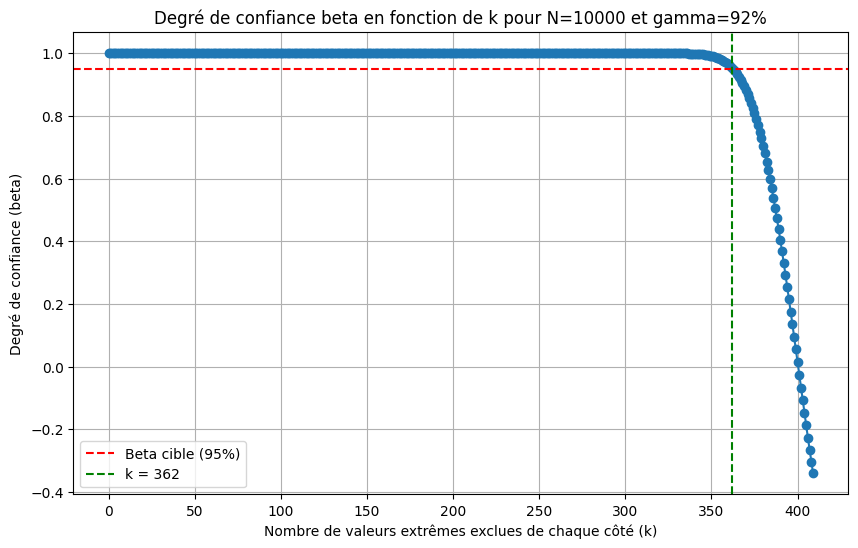

In [7]:
def plot_beta_vs_k(N, gamma, beta_target):
    """
    Trace le degré de confiance beta en fonction de k pour une taille d'échantillon donnée.
    
    Arguments :
    - N : int, taille de l'échantillon
    - gamma : float, proportion de la population couverte
    - beta_target : float, niveau de confiance souhaité
    """
    max_k = int(N * (1 - gamma)/2) + 10  # Plage de k
    k_values = range(0, max_k + 1)
    beta_values = [wilks_confidence_level(N, gamma, k) for k in k_values]
    
    plt.figure(figsize=(10,6))
    plt.plot(k_values, beta_values, marker='o')
    plt.axhline(y=beta_target, color='r', linestyle='--', label=f'Beta cible ({beta_target*100:.0f}%)')
    plt.axvline(x=k, color='g', linestyle='--', label=f'k = {k}')
    plt.xlabel('Nombre de valeurs extrêmes exclues de chaque côté (k)')
    plt.ylabel('Degré de confiance (beta)')
    plt.title(f'Degré de confiance beta en fonction de k pour N={N} et gamma={gamma*100:.0f}%')
    plt.legend()
    plt.grid(True)
    plt.show()

# Tracer beta vs k
plot_beta_vs_k(N, gamma, beta_target)


## Première propagation d'incertitudes

L'objectif est d'effectuer une première propagation d'incertitudes. 

Cette étude correspond à une des plus *basique, simple* possible (pas d'erreur de discrétisation, pas de coût prohibitif du code de calcul donc pas besoin d'un métamodèle). Cela ne veut pas dire qu'elle sera *basique, simple* pour vous... Mais au moins vous serez guidés et la prochaine que vous aurez à faire sera moins douloureuse.  

Autre chose: avec ce TD, vous allez aussi vérifier des implémentations qui vous resserviront dans d'autres TDs.

On souhaite étudier la propagation/réaction d'un polluant dans un milieu

- une source $S$ de polluant est mise en présence d'un milieu réactif (de constante de réaction $\lambda$)
- l'équation bilan de la réaction est 
$$
\left\{\begin{array}{lll}
u+A \longrightarrow B &:& \lambda,\\
u+B \longleftrightarrow u+B
\end{array}\right.
$$
Le réactif $A$ capture le polluant $u$ et le fixe en produit $B$, inerte.
- On souhaite étudier l'évolution de la concentration en polluant $u$ en fonction du temps $u(t)$
- Expliquer en quoi le modèle suivant
$$
\left\{\begin{array}{l}
\partial_t u(t) = \lambda u(t)+S,\\
u(t=0)=u_0,
\end{array}\right.
$$
est pertinent pour modèliser notre problème. Que dire sur $\lambda$? Sur $S$?

## Que pouvez-vous dire de ce modèle?

- énoncer les propriétés mathématiques du modèle
- proposer et implémenter une méthode de résolution numérique (astuce: tout est en python... Si la méthode n'est pas vectorisée, elle sera très lente...)

## Propriétés mathématiques et méthode numérique

- Cette équation est une EDO linéaire du premier ordre.
- Solution analytique : 
$$
u(t) = ( u_0 + \frac{S}{\lambda} )e^{\lambda t} - \frac{S}{\lambda}.
$$

### Méthode de résolution numérique
Nous allons utiliser la méthode d'Euler explicite pour approximer la solution.


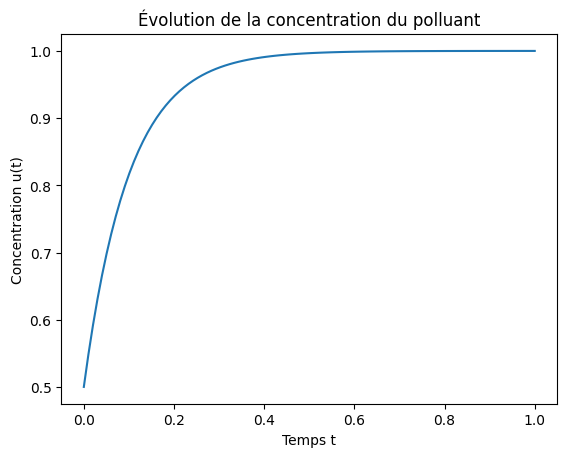

In [8]:
def u_analytique(t, u0, S, lam):
    return u0 * np.exp(lam * t) + (S / lam) * (np.exp(lam * t) - 1)

# Exemples de paramètres
u0 = 0.5
S = 10
lam = -10
t = np.linspace(0, 1, 100)

# Calcul de u(t)
u_t = u_analytique(t, u0, S, lam)

# Tracé
plt.plot(t, u_t)
plt.xlabel('Temps t')
plt.ylabel('Concentration u(t)')
plt.title('Évolution de la concentration du polluant')
plt.show()


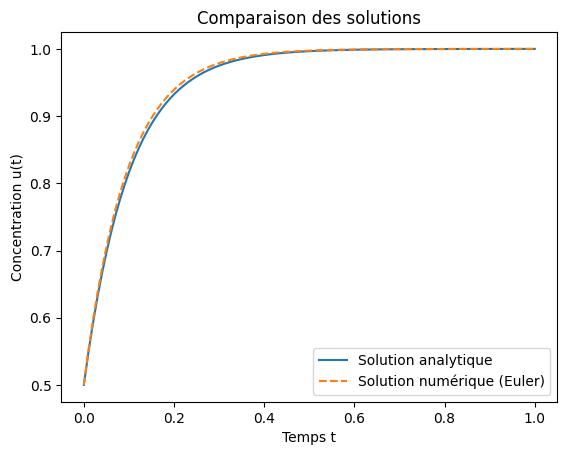

In [9]:
def euler_explicit(u0, S, lam, t):
    dt = t[1] - t[0]
    u = np.zeros_like(t)
    u[0] = u0
    for i in range(1, len(t)):
        u[i] = u[i-1] + dt * (lam * u[i-1] + S)
    return u

# Calcul numérique
u_t_euler = euler_explicit(u0, S, lam, t)

# Comparaison
plt.plot(t, u_t, label='Solution analytique')
plt.plot(t, u_t_euler, '--', label='Solution numérique (Euler)')
plt.xlabel('Temps t')
plt.ylabel('Concentration u(t)')
plt.title('Comparaison des solutions')
plt.legend()
plt.show()


## Modélisation probabiliste des sources d'incertitudes


Les paramètres du modèle ne sont pas bien connus: un expert propose de modéliser tous les paramètres incertains par des variables aléatoires gaussiennes centrées réduites indépendantes. Qu'en pensez-vous? No pb? Alors allez-y et Commenter.


## Réponse Modélisation probabiliste des sources d'incertitudes Réponse

Modéliser $u_0$, $S$, et $\lambda$ par des lois normales centrées réduites indépendantes peut introduire des biais en raison de leur domaine infini. Ce choix simplifie cependant les calculs en rendant les paramètres facilement manipulables.
Concernant la proposition de l'expert (variables gaussiennes centrées réduites) :


---> C'est problématique car :

- λ doit être négatif (constante de dégradation)
- S doit être positif (terme source)
- u₀ doit être positif (concentration initiale)
- Une gaussienne centrée réduite peut prendre n'importe quelle valeur réelle
- La modélisation par des gaussiennes pourrait donner des valeurs physiquement impossibles

---> La modélisation par lois uniformes est plus appropriée car :

- Elle garantit le respect des contraintes physiques
- Elle traduit bien une incertitude "bornée"
- Elle est cohérente avec les données recueillies


## 0) Modélisation probabiliste des sources d'incertitudes une fois des données recueillies


Les paramètres du modèle ne sont pas bien connus => des données ont été recueillies et trois lois ont été identifiées:
- loi uniforme sur $[0,1]$ pour $u_0$
- loi uniforme sur $[9,11]$ pour $S$
- loi uniforme sur $[-11,-9]$ pour $\lambda$


## 1) Propagation d'incertitudes au travers du modèle $t\rightarrow u(t)$

- Echantillonner les entrées précédemment modélisées (si validées!)
- Propager les incertitudes au travers du modèle pour estimer les moyenne et variance de $t\rightarrow u(t)$ au cours du temps
- Donner les intervalles de confiance sur ces deux quantités statistiques 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

# Nombre d'échantillons Monte Carlo
N_MC = 10000

# Échantillonnage des paramètres
u0_samples = np.random.uniform(0, 1, N_MC)
S_samples = np.random.uniform(9, 11, N_MC)
lam_samples = np.random.uniform(-11, -9, N_MC)


In [11]:
# Discrétisation du temps
t = np.linspace(0, 1, 100)
u_t_samples = np.zeros((N_MC, len(t)))

# Calcul de u(t) pour chaque échantillon
for i in range(N_MC):
    u_t_samples[i] = u_analytique(t, u0_samples[i], S_samples[i], lam_samples[i])


In [12]:
u_mean = np.mean(u_t_samples, axis=0)
u_var = np.var(u_t_samples, axis=0, ddof=1)


In [13]:
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = norm.ppf(1 - alpha / 2)
u_std_error = np.sqrt(u_var / N_MC)

u_mean_ci_lower = u_mean - z_score * u_std_error
u_mean_ci_upper = u_mean + z_score * u_std_error


In [14]:
# Degrés de liberté
df = N_MC - 1

# Quantiles de la loi chi-deux
chi2_lower = chi2.ppf(alpha / 2, df)
chi2_upper = chi2.ppf(1 - alpha / 2, df)

# Intervalles de confiance pour la variance
u_var_ci_lower = (df * u_var) / chi2_upper
u_var_ci_upper = (df * u_var) / chi2_lower


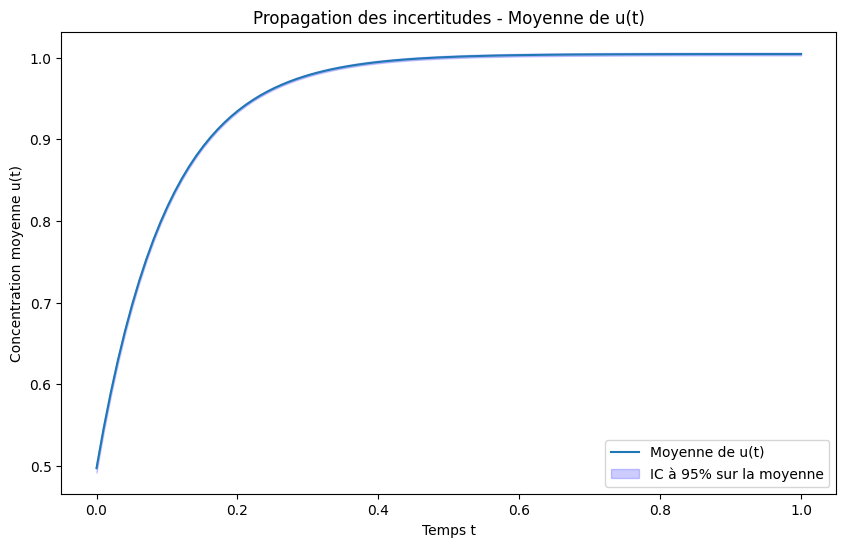

In [15]:
plt.figure(figsize=(10,6))
plt.plot(t, u_mean, label='Moyenne de u(t)')
plt.fill_between(t, u_mean_ci_lower, u_mean_ci_upper, color='b', alpha=0.2, label='IC à 95% sur la moyenne')
plt.xlabel('Temps t')
plt.ylabel('Concentration moyenne u(t)')
plt.title('Propagation des incertitudes - Moyenne de u(t)')
plt.legend()
plt.show()


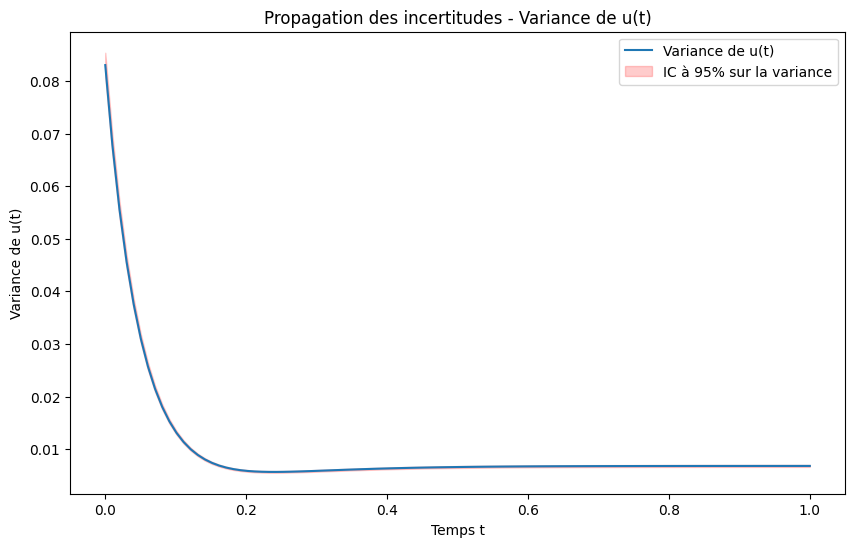

In [16]:
plt.figure(figsize=(10,6))
plt.plot(t, u_var, label='Variance de u(t)')
plt.fill_between(t, u_var_ci_lower, u_var_ci_upper, color='r', alpha=0.2, label='IC à 95% sur la variance')
plt.xlabel('Temps t')
plt.ylabel('Variance de u(t)')
plt.title('Propagation des incertitudes - Variance de u(t)')
plt.legend()
plt.show()


On remarque que pour un N_MC grand l'intervalle de confiance pour les observables (la moyenne et la variance) tend vers 0.

## 2) Propagation d'incertitudes au travers du modèle $t\rightarrow u(t)$

- A partir de la propagation précédente, donner un intervalle de tolérance à 95% (bi-latéral)
- Donner un degrés de confiance sur cet intervalle 

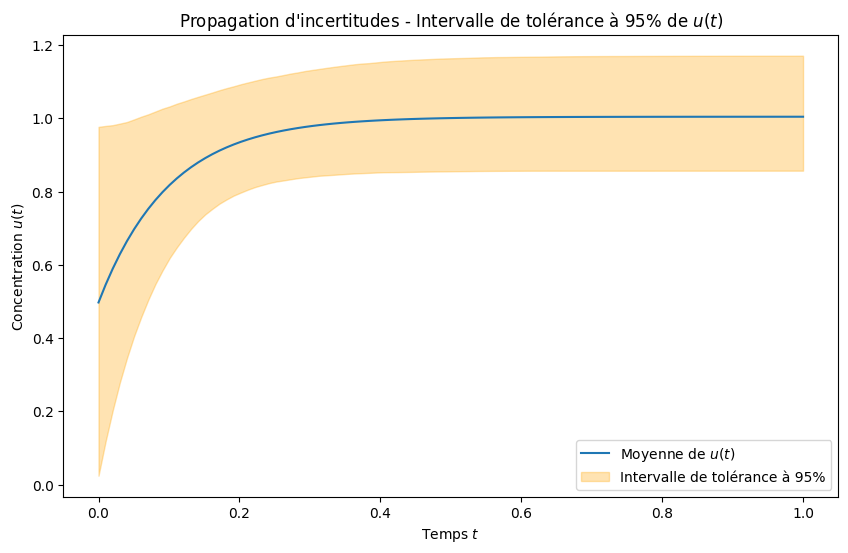

In [17]:
# Supposons que u_t_samples est un tableau de dimension (N_MC, len(t))
# contenant les simulations de u(t)

# Calcul des quantiles à 2,5% et 97,5%
u_lower = np.percentile(u_t_samples, 2.5, axis=0)
u_upper = np.percentile(u_t_samples, 97.5, axis=0)

# Calcul de la moyenne de u(t)
u_mean = np.mean(u_t_samples, axis=0)

# Tracé
plt.figure(figsize=(10,6))
plt.plot(t, u_mean, label='Moyenne de $u(t)$')
plt.fill_between(t, u_lower, u_upper, color='orange', alpha=0.3, label='Intervalle de tolérance à 95%')
plt.xlabel('Temps $t$')
plt.ylabel('Concentration $u(t)$')
plt.title('Propagation d\'incertitudes - Intervalle de tolérance à 95% de $u(t)$')
plt.legend()
plt.show()


In [32]:
N = 500 # Nombre total d'échantillons
gamma = 0.95  # Proportion couverte par l'intervalle
k = int(0.05 * N)  # Nombre de valeurs extrêmes exclues 

# Calcul du degré de confiance
beta = abs(wilks_confidence_level(N, gamma, k))
print(f"Degré de confiance pour l'intervalle de tolérance à {gamma*100:.1f}% : {beta*100:.2f}%")


Degré de confiance pour l'intervalle de tolérance à 95.0% : 99.80%


## 3) Propagation d'incertitudes au travers du modèle $t\rightarrow u(t)$

- Relancer les études précédentes avec une approximation de la solution par un schéma d'Euler explicite
- pour plusieurs pas de temps
- que remarquez-vous? 


Simulation avec Δt = 0.1


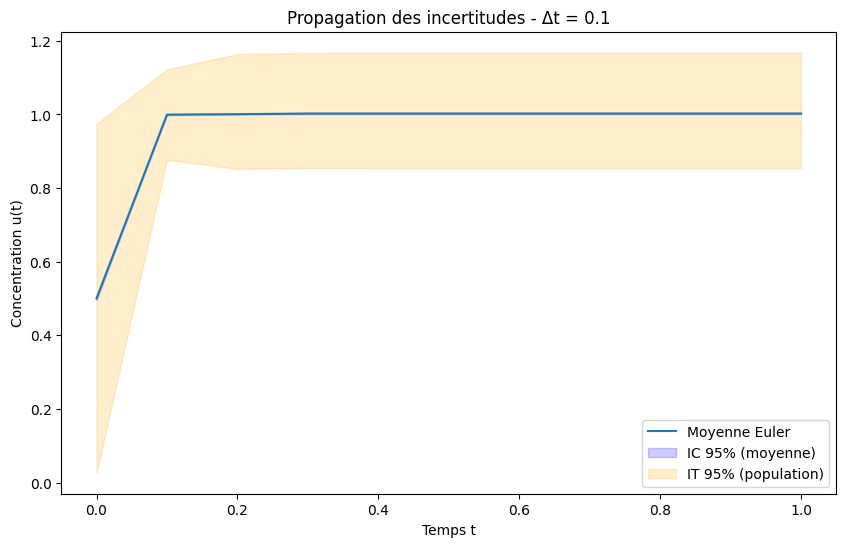


Simulation avec Δt = 0.01


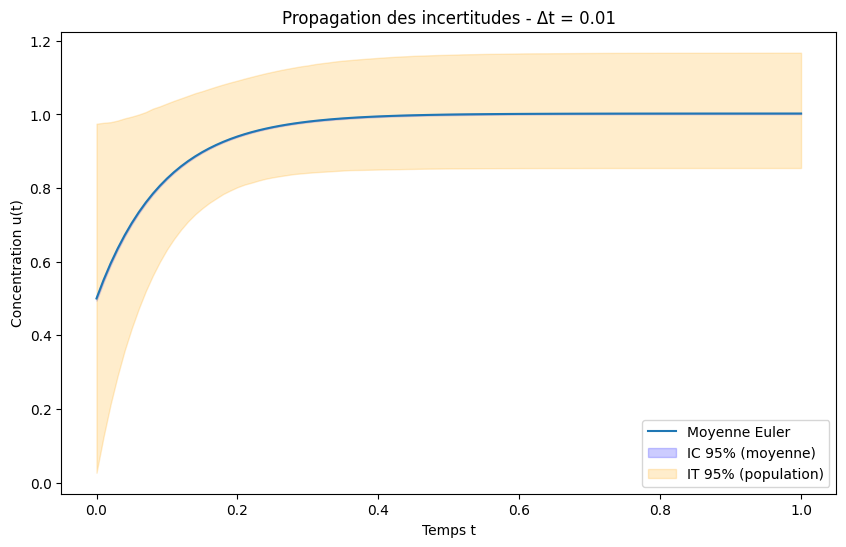


Simulation avec Δt = 0.001


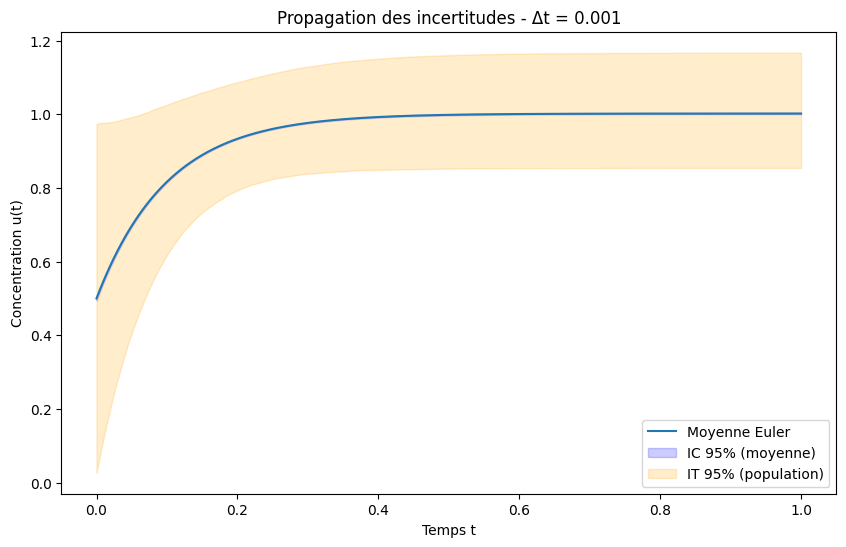

In [28]:
# Paramètres de simulation
N_MC = 10000
u0_samples = np.random.uniform(0, 1, N_MC)
S_samples = np.random.uniform(9, 11, N_MC)
lam_samples = np.random.uniform(-11, -9, N_MC)
dt_values = [0.1, 0.01, 0.001]

# Quantile pour IC (niveau de confiance 95%)
z_score = norm.ppf(0.975)

for dt in dt_values:
    print(f"\nSimulation avec Δt = {dt}")
    t = np.arange(0, 1 + dt, dt)
    u_t_samples_euler = np.zeros((N_MC, len(t)))
    
    for i in range(N_MC):
        u_t_samples_euler[i] = euler_explicit(u0_samples[i], S_samples[i], lam_samples[i], t)
    
    # Calcul de la moyenne et de l'écart-type
    u_mean_euler = np.mean(u_t_samples_euler, axis=0)
    u_std_euler = np.std(u_t_samples_euler, axis=0, ddof=1)
    
    # Calcul des intervalles de confiance pour la moyenne
    u_ci_lower = u_mean_euler - z_score * (u_std_euler / np.sqrt(N_MC))
    u_ci_upper = u_mean_euler + z_score * (u_std_euler / np.sqrt(N_MC))
    
    # Calcul des intervalles de tolérance
    u_tol_lower = np.percentile(u_t_samples_euler, 2.5, axis=0)
    u_tol_upper = np.percentile(u_t_samples_euler, 97.5, axis=0)
    
    # Tracé de la moyenne et des intervalles
    plt.figure(figsize=(10,6))
    plt.plot(t, u_mean_euler, label='Moyenne Euler')
    plt.fill_between(t, u_ci_lower, u_ci_upper, color='blue', alpha=0.2, label='IC 95% (moyenne)')
    plt.fill_between(t, u_tol_lower, u_tol_upper, color='orange', alpha=0.2, label='IT 95% (population)')
    plt.xlabel('Temps t')
    plt.ylabel('Concentration u(t)')
    plt.title(f'Propagation des incertitudes - Δt = {dt}')
    plt.legend()
    plt.show()


On remarque que les incertitudes sur les paramètres dominent les erreurs numériques introduites par le choix de $\Delta t$, comme le montrent les intervalles d'incertitude.